# Distribuciones mixtas - continua + continua
***

_Autor:_    __Jesús Casado__ <br> _Revisión:_ __10/03/2020__ <br>

__Introducción__<br>


__Cosas que arreglar__ <br>


__Referencias__<br>
[Szulczewski W. & Jakubowski W., 2018. The application of mixture distribution for the estimation of extreme floods in controlled catchment basins. _Water Resources Management (32)_, 3519-3534.](https://doi.org/10.1007/s11269-018-2005-6)<br>
[Kjeldsen T.R., Ahn H., Prosdocimi I. & Heo J.H., 2018. Mixture Gumbel models for extreme series including infrequent phenomena. _Hydrological Sciences Journal (63)_ 13-14, 1927-1940.](https://doi.org/10.1080/02626667.2018.1546956)<br>
[Langat P.K., Kumar L. & Koech R., 2019. Identification of the most suitable probability distribution models for maximum, minimum and mean streamflow. _Water 11_, 734.](https://doi.org/10.3390/w11040734)<br>


__Índice__ <br>

__[Cargar datos](#Cargar-datos)__ <br>

__[Análisis del nivel](#Análisis-del-nivel)__<br>
[Con eventos máximos de nivel](#Con-eventos-máximos-de-nivel)<br>
[Con eventos máximos de precipitación](#Con-eventos-máximos-de-precipitación)<br>
[Con todos los eventos](#Con-todos-los-eventos)<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pomegranate as pg

import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

In [2]:
from scipy import stats

In [3]:
from fitter import Fitter

In [4]:
%run POT_funciones.ipynb

## Cargar datos
Los datos se componen de la serie anual de extremos de nivel con su precipitación diaria asociada (_dataN_), y la serie anual de máximos de precipitación diaria con su nivel asociado (_dataP_). Estos dos conjuntos de extremos se combinan en _data_, eliminando eventos coincidentes en ambos conjuntos.

In [102]:
# extremos de nivel y precipitación asociada
dataN = pd.read_csv(rutaBase + '../data/Serie_extremos_marginal_P.csv', parse_dates=True,
                   index_col=0)
print('nº eventos: {0}\tnº variables: {1}'.format(*dataN.shape))

nº eventos: 39	nº variables: 2


In [103]:
# extremos de precipitación y nivel asociado
dataP = pd.read_csv(rutaBase + '../data/Serie_extremos_marginal_N.csv', parse_dates=True,
                   index_col=0)
print('nº eventos: {0}\tnº variables: {1}'.format(*dataP.shape))

nº eventos: 39	nº variables: 2


In [104]:
# combinar conjuntos de eventos extremos
data = pd.concat((dataN, dataP))
print('nº eventos: {0}\tnº variables: {1}'.format(*data.shape))

nº eventos: 78	nº variables: 2


## Análisis del nivel
### Con eventos máximos de nivel
Se ajusta la función de distribución de los eventos extremos de nivel.

,sumsquare_error,aic,bic,kl_div
gamma,8.397286,406.296573,-48.899787,inf
genextreme,8.406770,414.723088,-48.855764,inf
gumbel_r,8.454792,410.945794,-52.297181,inf
beta,8.912752,368.194211,-42.912817,inf
norm,8.918728,403.924521,-50.213801,inf


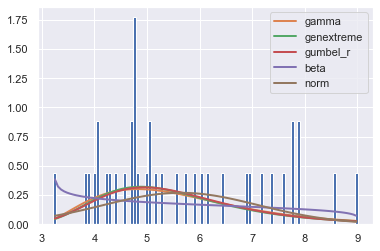

In [126]:
# datos
Nn = dataN.Nivel.values

# ajustar la distribución continua
distrs = ['beta', 'expon', 'weibull_min', 'gamma', 'genextreme', 'genpareto',
          'gumbel_r', 'norm', 'weibull_max']
F1 = Fitter(Nn, distributions=distrs, verbose=False)
F1.fit()
results1 = F1.summary().sort_values('sumsquare_error')

# extraer la distribución con menor AIC (criterio de información de Akaike)
distStr1 = results1.index[0]
distr1 = getattr(stats, distStr1)
pars1 = F1.fitted_param[distStr1]
model1 = distr1(*pars1)

results1

### Con eventos máximos de precipitación
Se ajusta la función de distribución del nivel asociado a los eventos extremos de precipitación diaria.

,sumsquare_error,aic,bic,kl_div
gamma,4.863998,432.586957,-70.195654,inf
gumbel_r,4.864886,435.348125,-73.852090,inf
weibull_min,4.869912,426.125396,-70.148259,inf
genextreme,4.875213,432.772242,-70.105834,inf
weibull_max,4.875220,432.773948,-70.105773,inf


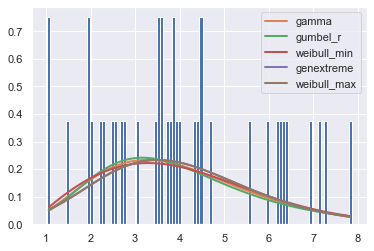

In [129]:
# datos
Np = dataP.Nivel.values

# ajustar la distribución continua
F2 = Fitter(Np, distributions=distrs, verbose=False)
F2.fit()
results2 = F2.summary().sort_values('sumsquare_error')

# extraer la distribución con menor AIC (criterio de información de Akaike)
distStr2 = results2.index[0]
distr2 = getattr(stats, distStr2)
pars2 = F2.fitted_param[distStr2]
model2 = distr2(*pars2)

results2

### Con todos los eventos
Se busca la forma de combinar los ajustes de los dos conjuntos de extremos para crear una distribución mixta para el conjunto de todos los eventos extremos.

La función de densidad mixta ($PDF_{mixta}$) es la media ponderada de las funciones de densidad de cada uno de los grupos de eventos, siendo el peso la probabilidad de que un valor de $X$ de la variable $x$ pertenezca a uno u otro conjunto de eventos:
$$PDF_{mixta} = a \cdot PDF_1+b\cdot PDF_2 = \frac{PDF_1}{PDF_1+PDF_2} PDF_1+\frac{PDF_2}{PDF_1+PDF_2} PDF_2$$
donde:
$$PDF_n=P(x<=X)$$

La función de distribución mixta ($CDF_{mixta}$) es la integración de la $PDF_{mixta}$ anteriormente definida.
$$CDF_{mixta} = \int PDF_{mixta} dx = \int a \cdot PDF_1+b\cdot PDF_2 dx = \int \frac{PDF_1^2}{PDF_1+PDF_2}+\frac{PDF_2^2}{PDF_1+PDF_2} dx$$
No sabiendo resolver esta integración analíticamente, resuelvo la $CDF_{mixta}$ por tres aproximaciones:
1.  Como la <font color='steelblue'>media de las funciones de distribución de ambos conjuntos</font>. Puesto que ambos conjuntos tienen el número de eventos, la probabilidad de que un evento aleatorio pertenezca a uno de ellos es 0.5; de ahí el uso de la media. Esto no tiene en cuenta que la pertenencia a uno u otro grupo depende del valor de $x$.
2.  Como la <font color='steelblue'>media ponderada de las funciones de distribución de ambos grupos</font>. Como pesos en la ponderación se utilizan los mismos que los utilizados en la combinación de las funciones de densidad ($a$ y $b$), es decir, se tiene en cuenta el valor de $x$ en la pertenencia a uno u otro grupo.
3.  <font color='steelblue'>Resolución numérica</font> como la suma acumulada de la $PDF$. Puesto que el máximo de la $CDF$ ha de ser teóricamente 1 (próximo a 1 en la realidad), el resultado de la suma acumulada se normaliza con el máximo obtenido en la aproximación 2.

In [131]:
# datos
Nnp = data.Nivel.values

In [187]:
# cdf y pdf de cada uno de los grupos
x = np.linspace(0, 18, 1000)
cdf1, pdf1 = model1.cdf(x), model1.pdf(x)
cdf2, pdf2 = model2.cdf(x), model2.pdf(x)

In [205]:
# cdf del conjunto total
# 1. media de las dos cdfs
PDF1 = .5 * (pdf1 + pdf2)
CDF1 = .5 * (cdf1 + cdf2)

# 1. ponderado por la probabilidad de que un valor de 'x' pertenezca a uno u otro grupo
a, b = pdf1 / (pdf1 + pdf2), pdf2 / (pdf1 + pdf2)
PDF2 = a * pdf1 + b * pdf2
CDF2 = a * cdf1 + b * cdf2

# 3. resolución numérica: suma acumulada de la pdf posteriormente normalizada
CDF3 = np.cumsum(PDF2)
CDF3 *= CDF2.max() / CDF3.max()

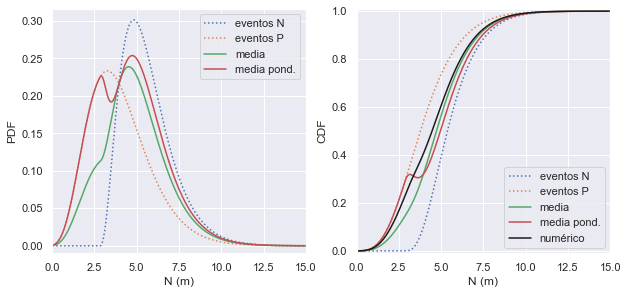

In [218]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4.5), sharex=True)

ax[0].plot(x, model1.pdf(x), ls=':', label='eventos N')
ax[0].plot(x, model2.pdf(x), ls=':', label='eventos P')
ax[0].plot(x, PDF1, label='media')
ax[0].plot(x, PDF2, label='media pond.')
eps = 1e-2
ax[0].set(ylim=(0 - eps), ylabel='PDF', xlabel='N (m)')
ax[0].legend()

ax[1].plot(x, cdf1, ls=':', label='eventos N')
ax[1].plot(x, cdf2, ls=':', label='eventos P')
ax[1].plot(x, CDF1, label='media')
ax[1].plot(x, CDF2, label='media pond.')
ax[1].plot(x, CDF3, c='k', label='numérico')
ax[1].set(ylim=(0 - eps, 1 + eps), xlim=(0, 15), ylabel='CDF', xlabel='N (m)')
ax[1].legend();

La aproximación mediante la media parece incorrecta en la $PDF$ generada, puesto que se genera un quiebro para el valor de nivel en el que inicia la ocurrencia del conjuntos de eventos N ($N=3m$ aprox.). La $CDF$, en cambio, parece adecuada a simple vista, puesto que es una función continua y monotónicamente creciente.

La aproximación mediante la media ponderada parece la más adecuada para generar la $PDF$; se obtiene una curva continua con dos modas correspondientes en cierto modo con los picos de las $PDF$ de los dos conjuntos de eventos. Sin embargo, la $CDF$ es errónea puesto que no es monotónicamente creciente.

Dados los problemas encontrados en las dos aproximaciones anteriores, se decide adoptar la $PDF$ obtenida mediante la media ponderada y definir la $CDF$ numéricamente a partir de ésta, es decir, su suma acumulada y normalizada para que el máximo no sea superior a 1. La $CDF$ obtenida es monotónicamente creciente y se acerca más a la de los eventos P para valores bajos de nivel, y a la de los eventos N para valores altos de nivel.

### Funciones
Estas funciones resuelven numéricamente la $CDF$ y su inversa ($PPF$) de la distribución mixta, dados los modelos ajustados para los dos conjuntos de extremos.

In [272]:
def cdfMixta(x, model1, model2, xmax, n=1000):
    """Resolución numérica de la función de distribución acumulada de una distribución mixta compuesta de dos conjuntos.
                
        Parámetros:
        -----------
        x:         array (m). Valores de la variable
        model1:    callable. Distribución ajustada (con parámetros) para el conjunto de eventos 1
        model2:    callable. Distribución ajustada (con parámetros) para el conjunto de eventos 2
        xmax:      float. Valor máximo de la variable 'x' en la resolución numérica
        n:         int. Número de discretizaciones para la resolución numérica
        
        Salida:
        -------
        cdf:       array (m). Probabilidad de no excedencia asociada a los valores de 'x'"""
    
    # asegurar que 'x' es un array
    if isinstance(x, int) | isinstance(x, float):
        x = np.array([x]).astype(float)
    elif isinstance(x, list):
        x = np.array(x).astype(float)
    
    # cdf y pdf de cada uno de los grupos
    xs = np.linspace(0, xmax, 1000)
    cdf1, pdf1 = model1.cdf(xs), model1.pdf(xs)
    cdf2, pdf2 = model2.cdf(xs), model2.pdf(xs)
    
    # pdf mixta
    a, b = pdf1 / (pdf1 + pdf2), pdf2 / (pdf1 + pdf2)
    pdfMix = a * pdf1 + b * pdf2
    cdfAux = a * cdf1 + b * cdf2
    
    # cdf mixta
    cdfMix = np.cumsum(pdfMix)
    cdfMix *= cdfAux.max() / cdfMix.max()
    
    # calcular la probabilidad de no excedencia de los valores de 'x'
    cdf = np.zeros_like(x)
    for i, X in enumerate(x):
        cdf[i] = cdfMix[np.argmin(abs(xs - X))]
        
    return cdf

In [279]:
def ppfMixta(q, model1, model2, xmax, n=1000):
    """Resolución numérica de la inversa de la función de distribución acumulada de una distribución mixta compuesta de dos conjuntos.
                
        Parámetros:
        -----------
        q:         array (m). Valores de la probabilidad de excendencia
        model1:    callable. Distribución ajustada (con parámetros) para el conjunto de eventos 1
        model2:    callable. Distribución ajustada (con parámetros) para el conjunto de eventos 2
        xmax:      float. Valor máximo de la variable 'x' en la resolución numérica
        n:         int. Número de discretizaciones para la resolución numérica
        
        Salida:
        -------
        ppf:       array (m). Cuantil asociado a los valores de 'q'"""
    
    # asegurar que 'x' es un array
    if isinstance(q, int) | isinstance(q, float):
        q = np.array([q]).astype(float)
    elif isinstance(q, list):
        q = np.array(q).astype(float)
    
    # cdf y pdf de cada uno de los grupos
    xs = np.linspace(0, xmax, 1000)
    cdf1, pdf1 = model1.cdf(xs), model1.pdf(xs)
    cdf2, pdf2 = model2.cdf(xs), model2.pdf(xs)
    
    # pdf mixta
    a, b = pdf1 / (pdf1 + pdf2), pdf2 / (pdf1 + pdf2)
    pdfMix = a * pdf1 + b * pdf2
    cdfAux = a * cdf1 + b * cdf2
    
    # cdf mixta
    cdfMix = np.cumsum(pdfMix)
    cdfMix *= cdfAux.max() / cdfMix.max()
    
    # calcular la probabilidad de no excedencia de los valores de 'x'
    ppf = np.zeros_like(q)
    for i, Q in enumerate(q):
        ppf[i] = xs[np.argmin(abs(cdfMix - Q))]
        
    return ppf

In [277]:
cdfMixta(15, model1, model2, 18)

array([0.99993533])

In [278]:
ppfMixta(.99, model1, model2, 18)

array([9.83783784])

In [372]:
class mixedDistributionCC:
    """Distribución mixta compuesta de dos distribuciones continuas asociadas a dos conjuntos
    de la misma variable.
    """
    
    def __init__(self, data1, data2):
        """Parámetros:
        --------------
        data1:    array(n,). Valores de la variable de estudio en el conjunto 1
        data2:    array(m,). Valores de la variable de estudio en el conjunto 2
        """
        
        self.data1 = data1
        self.data2 = data2
        
    def fit(self, data, distrs, crit):
        """Ajusta la función de distribución más apropiada a los datos en base al criterio definido
        
        Parámetros:
        -----------
        distrs:     list of strings. Lista con el nombre de SciPy de las distribuciones a ajustar
        crit:       string. Criterio en función del que seleccionar la mejor distribución: 'sumsquare_error'; 'aic' criterio de Akaike; 'bic', criteiro bayesiano
        
        Salidas:
        --------
        model:      callable. Función de distribución ajustada (con los parámetros definidos)
        fitResults: data frame. Tabla con los resultados de la bondad del ajuste para cada distribución"""
        
        # ajustar la distribución continua
        F = Fitter(data, distributions=distrs, verbose=False)
        F.fit()
        results = F.summary().sort_values(crit)
        self.fitResults = results

        # extraer la distribución con menor AIC (criterio de información de Akaike)
        distStr = results.index[0]
        distr = getattr(stats, distStr)
        pars = F.fitted_param[distStr]
        model = distr(*pars)
        
        return model
    
    def numericalSolution(self, model1, model2, eps=1e-4, n=1000):
        """Cálculo numérico de la 'cdf' para un vector linealmente espaciado de valores de la variable de estudio 'x'
        
        Parámetros:
        -----------
        model1:    callable. Distribución ajustada (con parámetros) para el conjunto de eventos 1
        model2:    callable. Distribución ajustada (con parámetros) para el conjunto de eventos 2
        eps:       float. Aproximación a la probabilidad acumulada de 0 y 1 para calcular el valor mínimo y máximo que puede tomar 'x'
        n:         int. Número de discretizaciones para la resolución numérica
        
        Salidas:
        --------
        Como métodos:
        xs:        array(n,). Valores de la variable 'x' para los que se calcula la cdf
        qs:        array(n,). Probabilidad de no excedencia de cada uno de los valores en 'xs'
        """
        
        # vector de valores de la variable
        xmin = np.floor(min(model1.ppf(eps), model2.ppf(eps)))
        xmax = np.ceil(max(model1.ppf(1 - eps), model2.ppf(1 - eps)))
        xs = np.linspace(xmin, xmax, n)
        
        # cdf y pdf de cada uno de los conjuntos
        cdf1, pdf1 = model1.cdf(xs), model1.pdf(xs)
        cdf2, pdf2 = model2.cdf(xs), model2.pdf(xs)

        # pdf mixta
        a, b = pdf1 / (pdf1 + pdf2), pdf2 / (pdf1 + pdf2)
        pdfMix = a * pdf1 + b * pdf2
        cdfAux = a * cdf1 + b * cdf2

        # cdf mixta
        cdfMix = np.cumsum(pdfMix)
        cdfMix *= cdfAux.max() / cdfMix.max()
        
        self.xs = xs
        self.qs = cdfMix
        
    
    def cdf(self, x, model1, model2, eps=1e-4, n=1000):
        """Resolución numérica de la función de distribución acumulada de una distribución mixta compuesta de dos conjuntos.
                
        Parámetros:
        -----------
        x:         array (m). Valores de la variable
        model1:    callable. Distribución ajustada (con parámetros) para el conjunto de eventos 1
        model2:    callable. Distribución ajustada (con parámetros) para el conjunto de eventos 2
        eps:       float. Aproximación a la probabilidad acumulada de 0 y 1 para calcular el valor mínimo y máximo que puede tomar 'x'
        n:         int. Número de discretizaciones para la resolución numérica
        
        Salida:
        -------
        cdf:       array (m). Probabilidad de no excedencia asociada a los valores de 'x'"""
    
        # asegurar que 'x' es un array
        if isinstance(x, int) | isinstance(x, float):
            x = np.array([x]).astype(float)
        elif isinstance(x, list):
            x = np.array(x).astype(float)
        
        # resolución numérica
        self.numericalSolution(model1, model2, eps, n)

        # calcular la probabilidad de no excedencia de los valores de 'x'
        cdf = np.zeros_like(x)
        for i, X in enumerate(x):
            cdf[i] = self.qs[np.argmin(abs(self.xs - X))]

        return cdf
    
    def ppf(self, q, model1, model2, eps=1e-4, n=1000):
        """Resolución numérica de la inversa de la función de distribución acumulada de una distribución mixta compuesta de dos conjuntos.

        Parámetros:
        -----------
        q:         array (m). Valores de la probabilidad de excendencia
        model1:    callable. Distribución ajustada (con parámetros) para el conjunto de eventos 1
        model2:    callable. Distribución ajustada (con parámetros) para el conjunto de eventos 2
        eps:       float. Aproximación a la probabilidad acumulada de 0 y 1 para calcular el valor mínimo y máximo que puede tomar 'x'
        n:         int. Número de discretizaciones para la resolución numérica

        Salida:
        -------
        ppf:       array (m). Cuantil asociado a los valores de 'q'"""

        # asegurar que 'x' es un array
        if isinstance(q, int) | isinstance(q, float):
            q = np.array([q]).astype(float)
        elif isinstance(q, list):
            q = np.array(q).astype(float)
        
        # resolución numérica
        self.numericalSolution(model1, model2, eps, n)
        
        # calcular la probabilidad de no excedencia de los valores de 'x'
        ppf = np.zeros_like(q)
        for i, Q in enumerate(q):
            ppf[i] = self.xs[np.argmin(abs(self.qs - Q))]

        return ppf

In [373]:
# declarar la distribución mixta
mdN = mixedDistributionCC(Nn, Np)

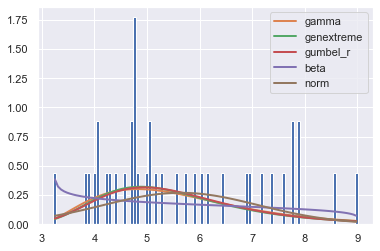

In [374]:
# ajustar conjunto de datos 1
model1 = mdN.fit(mdN.data1, distrs, 'sumsquare_error')

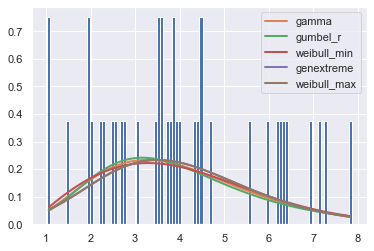

In [375]:
# ajustar conjunto de datos 2
model2 = mdN.fit(mdN.data2, distrs, 'sumsquare_error')

In [376]:
# cdf de la distribución mixta
x = np.linspace(0, 15, 1000)
cdf = mdN.cdf(x, model1, model2)

# ppf (inversa de la cdf) de la distribución mixta
q = np.linspace(0, 1 - 1e-4, 1000)
ppf = mdN.ppf(q, model1, model2)

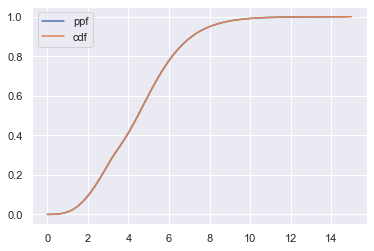

In [377]:
plt.plot(ppf, q, label='ppf')
plt.plot(x, cdf, label='cdf')
plt.legend();